# PR 8.1 - Regressiemodellen in Machine Learning

Van Pjotr en Sennen

De opdracht van deze week is:

Great Outdoors wil graag weten hoeveel zij gaat verkopen op basis van een set onafhankelijke variabelen. Daarom wil zij een model trainen op basis van reeds bekende data, zodat deze volgend jaar in gebruik kan worden genomen. Je doet dus het volgende met de reeds bekende data:
- Bedenk met welke onafhankelijke variabelen, die ook uit meerdere databasetabellen kunnen komen, dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
- Pas waar nodig Dummy Encoding toe.
- Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
- Train het regressiemodel.
- Evalueer de performance van je getrainde regressiemodel.

#### Wat doen we ermee?
We kunnen met dit model voorspellen hoeveel we gaan verkopen op basis van de onafhankelijke variabelen. Dit kan ons helpen om in te schatten hoeveel we moeten inkopen en hoeveel we moeten produceren. Dit kunnen we bijvoorbeeld gebruiken voor:
- Globaal productverkoop
- Verkoop per productlinie
- Verkoop per individueel product

Hieronder zullen we de libaries importeren die we nodig hebben voor de opdrachten.

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import sqlite3

Om te beginnen maken we een connectie naar alle belangrijke data die wij nodig hebben. Zoals inventory, forecast, details en header.

In [58]:
# Deze had ik niet meer nodig.
forecast = pd.read_csv('data/GO_SALES_PRODUCT_FORECASTData.csv', sep=',')
inventory = pd.read_csv('data/GO_SALES_INVENTORY_LEVELSData.csv', sep=',')

# Verbind met de database en haal de tabellen op.
conn = sqlite3.connect('data/go_sales.sqlite')
details = pd.read_sql(con=conn, sql='SELECT * FROM order_details')
header = pd.read_sql(con=conn, sql='SELECT * FROM order_header')
product = pd.read_sql_query("SELECT * FROM product;", conn)

# Drop de kolommen die niet nodig zijn en irrelevant.
details = details[details.columns.drop(list(details.filter(regex="TRIAL")))]
header = header[header.columns.drop(list(header.filter(regex="TRIAL")))]

Hierna mergen we de order details en header met elkaar. Dit doen we op basis van de order id. We mergen de inventory met de order details en header op basis van de product id. We mergen de forecast met de inventory op basis van de product id.

In [59]:
order = pd.merge(header, details, on='ORDER_NUMBER').merge(product, on='PRODUCT_NUMBER')
order

,ORDER_NUMBER,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,ORDER_DETAIL_CODE,PRODUCT_NUMBER,...,UNIT_SALE_PRICE,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,TRIAL888
0,1153,Ultra Sports,4,6,50,18,2020-04-14,7,47747,2,...,11.81,15-2-2011,1,9.22,.23,P02CE1CG1.jpg,EN,TrailChef Canteen,Aluminum canteen. Rugged fleece-lined cover wi...,T
1,1153,Ultra Sports,4,6,50,18,2020-04-14,7,47994,32,...,25.1,15-2-2011,5,16.67,.33,P32CE1LT5.jpg,EN,Firefly 2,A high quality aluminum flashlight with Krypto...,T
2,1153,Ultra Sports,4,6,50,18,2020-04-14,7,48015,35,...,24.82,26-10-2016,5,17.78,.25,P35CE1LT5.jpg,EN,Firefly Multi-light,This light can be used as either a flashlight ...,T
3,1153,Ultra Sports,4,6,50,18,2020-04-14,7,48022,36,...,31.44,15-2-2011,5,18.05,.4,P36CE1LT5.jpg,EN,EverGlow Single,Light output approximates a 100 W bulb. Single...,T
4,1153,Ultra Sports,4,6,50,18,2020-04-14,7,48049,39,...,61.38,5-3-2013,5,40.63,.37,P39CE1LT5.jpg,EN,EverGlow Butane,Adjustable brightness control with auto igniti...,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110788,52,...,33.25,10-1-2021,8,19,.5,P52ME2CA8.jpg,EN,Granite Pulley,"Light, simple and strong, a great all purpose ...",T
43059,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110816,56,...,15.75,10-1-2021,8,9,.5,P56ME2CA8.jpg,EN,Granite Chalk Bag,Nylon web bag perfect for holding several stic...,T
43060,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110827,57,...,70,10-1-2021,9,40,.5,P57ME2TL9.jpg,EN,Granite Ice,A general purpose mountaineering axe for snow ...,T
43061,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110914,78,...,94.05,15-2-2011,13,79.19,.2,P78PA3BN13.jpg,EN,Seeker 35,This 7 x 35 model is economical and performs w...,T


Hier pakken we de kolommen moeten order date converteren.

In [60]:
order = order.drop(columns=["RETAILER_NAME", "PRODUCT_IMAGE", "PRODUCT_NAME", "DESCRIPTION", "LANGUAGE"])
# Selecteren van onafhankelijke variabelen en afhankelijke variabele
order['YEAR'] = pd.DatetimeIndex(pd.to_datetime(order["ORDER_DATE"])).year
order['MONTH'] = pd.DatetimeIndex(pd.to_datetime(order["ORDER_DATE"])).month
# Laat onnodige kolommen vallen
order = order[['PRODUCT_NUMBER', 'QUANTITY', 'YEAR', 'MONTH']]

In dit stukje code wordt er gecontroleerd op ongeldige waarden in onze order dataset. Als er een ongeldige waarde is, dam krijgen we een error.

In [61]:
# Bevestig dat er geen null of NaN waardes in de data zitten
bad_data = order[order.isna().any(axis=1) | order.isnull().any(axis=1)]
if len(bad_data) > 0:
    raise ValueError("Ongeldige waardes in brondata van orders")

order = order.groupby(['PRODUCT_NUMBER', 'YEAR', 'MONTH'])
order = order.aggregate('sum').reset_index()

Hier voeren we een aantal data-verwerkingsstappen uit met behulp van de pandas-bibliotheek.

In [62]:
# Samenvoegen van forecast en inventory data
inventory = inventory.rename(columns={"INVENTORY_MONTH": "MONTH", "INVENTORY_YEAR": "YEAR", "INVENTORY_COUNT": "INVENTORY_QUANTITY"})
df = pd.merge(forecast, inventory, on=['MONTH', 'YEAR', 'PRODUCT_NUMBER'])

# Bevestig dat er geen null of NaN waardes in de data zitten
bad_data = df[df.isna().any(axis=1) | df.isnull().any(axis=1)]
if len(bad_data) > 0:
    raise ValueError("Ongeldige waardes in brondata van orders")

# Selecteren van onafhankelijke variabelen en afhankelijke variabele
# Product number, quantity, year, month, forecast, inventory
df['PRODUCT_NUMBER'] = df['PRODUCT_NUMBER'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)
df['YEAR'] = df['YEAR'].astype(int)
order['PRODUCT_NUMBER'] = order['PRODUCT_NUMBER'].astype(int)
order['MONTH'] = order['MONTH'].astype(int)
order['YEAR'] = order['YEAR'].astype(int)

df = pd.merge(order, df, on=['MONTH', 'YEAR', 'PRODUCT_NUMBER'])

# Bevestig dat er geen null of NaN waardes in de data zitten
bad_data = df[df.isna().any(axis=1) | df.isnull().any(axis=1)]
if len(bad_data) > 0:
    raise ValueError("Ongeldige waardes in brondata van orders")

Hier pakken we de product uit en zorgen we ervoor dat de product id en de product name in een dataframe komen te staan in de juiste type.

In [63]:
product['PRODUCT_NUMBER'] = product['PRODUCT_NUMBER'].astype(int)
product['PRODUCTION_COST'] = product['PRODUCTION_COST'].astype(float)
product['MARGIN'] = product['MARGIN'].astype(float)
product = product[['PRODUCT_NUMBER', 'PRODUCTION_COST', 'PRODUCT_TYPE_CODE', 'MARGIN']]

df = pd.merge(product, df, on='PRODUCT_NUMBER').drop_duplicates()

# Bevestig dat er geen null of NaN waardes in de data zitten
bad_data = df[df.isna().any(axis=1) | df.isnull().any(axis=1)]
if len(bad_data) > 0:
    raise ValueError("Ongeldige waardes in brondata van orders")

df

,PRODUCT_NUMBER,PRODUCTION_COST,PRODUCT_TYPE_CODE,MARGIN,YEAR,MONTH,QUANTITY,EXPECTED_VOLUME,INVENTORY_QUANTITY
0,1,4.0,1,0.33,2020,1,594,524,2007
1,1,4.0,1,0.33,2020,2,344,403,2263
2,1,4.0,1,0.33,2020,3,898,750,1965
3,1,4.0,1,0.33,2020,4,1328,1386,1837
4,1,4.0,1,0.33,2020,5,640,544,2397
...,...,...,...,...,...,...,...,...,...
3865,99,2.0,17,0.60,2022,8,264,299,4037
3866,99,2.0,17,0.60,2022,9,256,241,3781
3867,99,2.0,17,0.60,2022,10,242,334,3539
3868,99,2.0,17,0.60,2022,11,148,182,3391


Hier wordt een dataset voorbereid voor verdere analyse, waar we de order details en header samenvoegen. Daarna maken we ook nog dummie data aan via maand en product type.

In [64]:
df['MONTH'] = df['MONTH'].astype(str)
month_dummies = pd.get_dummies(df.loc[:,['MONTH']])

df = pd.concat([df, month_dummies], axis=1)
df.drop(['MONTH'], axis=1)


df['PRODUCT_TYPE_CODE'] = df['PRODUCT_TYPE_CODE'].astype(str)
product_line_dummies = pd.get_dummies(df.loc[:,['PRODUCT_TYPE_CODE']])

df = pd.concat([df, product_line_dummies], axis=1)
df.drop(['PRODUCT_TYPE_CODE'], axis=1)

df.drop(['PRODUCT_NUMBER'], axis=1)

df = df.rename(columns=str.lower)

Nu gaan we de tabellen vertical en horizontaal snijden. We maken een tabel met de onafhankelijke variabelen en een tabel met de afhankelijke variabelen. de afhankelijke variabele is de order quantity en de onafhankelijke variabelen zijn de product type en de maand.

In [65]:
x = df.drop('quantity', axis=1)
y = df.loc[:,['quantity']]
x

,product_number,production_cost,product_type_code,margin,year,month,expected_volume,inventory_quantity,month_1,month_10,...,product_type_code_2,product_type_code_20,product_type_code_21,product_type_code_3,product_type_code_4,product_type_code_5,product_type_code_6,product_type_code_7,product_type_code_8,product_type_code_9
0,1,4.0,1,0.33,2020,1,524,2007,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1,4.0,1,0.33,2020,2,403,2263,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,4.0,1,0.33,2020,3,750,1965,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,4.0,1,0.33,2020,4,1386,1837,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,4.0,1,0.33,2020,5,544,2397,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,99,2.0,17,0.60,2022,8,299,4037,False,False,...,False,False,False,False,False,False,False,False,False,False
3866,99,2.0,17,0.60,2022,9,241,3781,False,False,...,False,False,False,False,False,False,False,False,False,False
3867,99,2.0,17,0.60,2022,10,334,3539,False,True,...,False,False,False,False,False,False,False,False,False,False
3868,99,2.0,17,0.60,2022,11,182,3391,False,False,...,False,False,False,False,False,False,False,False,False,False


Nu gaan we de data trainenen en testen. We maken een train en test set aan. We trainen de data en voorspellen de data. Voor beide x en y.

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

Met de training data en de test data gesplitst en getrained, gaan we nu beginnnen aan het maken van een model.

In [67]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train,y_train)
reg_model

LinearRegression()

Hier gaan we met het gegeven regressiemodel de data voorspellen en kijken hoe goed het model is. Dat zullen we later laten zien.

In [68]:
y_pred = reg_model.predict(x_test)

De voorspellingen zijn gedaan en worden nu in een dataframe omgezet, we veranderen de naam van een van de kolomen naar 'Predicted_Quantity'.

In [69]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns={0: 'predicted_quantity'})
prediction_df

,predicted_quantity
0,355.884218
1,361.258908
2,632.380826
3,334.110850
4,309.481457
...,...
576,2048.826463
577,37.326829
578,2416.263142
579,297.915070


Hierin worden de voorspellingen met de test data toegevoegd en wordt daarna gecheckt of de predicted_quantity niet null of NaN is.

In [79]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['quantity'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['predicted_quantity'].notna(),:]

,quantity,predicted_quantity
0,282,355.884218
1,294,361.258908
2,586,632.380826
3,772,334.110850
4,350,309.481457
...,...,...
576,2142,2048.826463
577,26,37.326829
578,2828,2416.263142
579,246,297.915070


Nu wordt het regressie model in beeld gebracht. Nu zal via de grafiek te zien zijn hoe goed het model is. Dit doen we door gebruik te maken van pyplot en seaborn.

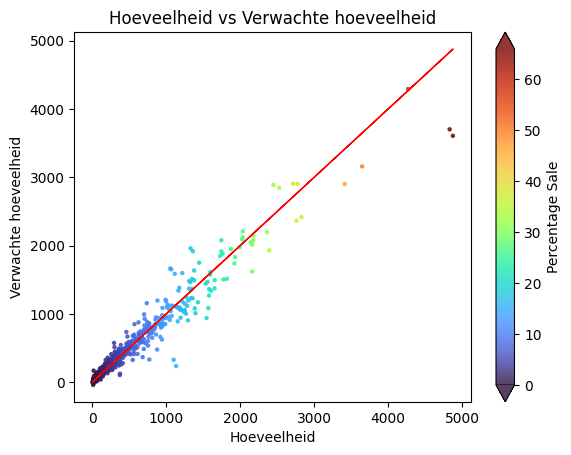

In [78]:
colors = np.interp(y_test_prediction_merge["quantity"], (y_test_prediction_merge["quantity"].min(), y_test_prediction_merge["quantity"].max()), (0, 66))
plt.scatter(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'], s=5, c=colors, cmap="turbo", alpha=0.8)
plt.xlabel('Hoeveelheid')
plt.ylabel('Verwachte hoeveelheid')
plt.title('Hoeveelheid vs Verwachte hoeveelheid')
plt.colorbar(orientation="vertical", label="Percentage Sale", extend="both")
line_size = np.linspace(y_test_prediction_merge["quantity"].min(), y_test_prediction_merge["quantity"].max(), 100)
plt.arrow(line_size.min(), line_size.min(), line_size.max(), line_size.max(), color='red', linestyle='-')
plt.show()

Met deze functie gaan we de gemiddelde kwadratische fout berekenen.

In [72]:
mean_squared_error(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])

23613.888133100518

Hieronder doen we ook nog het absolute gemiddelde fout berekenen.

In [73]:
mean_absolute_error(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])

84.00209447113029

Hier kunnen we het model scoren op hoe goed het model is. Dit doen we door de reg_model te berekenen. Dus daarna de accuracy score te berekenen.

In [74]:
reg_model.score(x_test, y_test)

0.9393666221547838